# Clasificación usando Árbol de decisión

**Autor:** Jazna Meza Hidalgo

**Correo Electrónico:** ja.meza@profesor.duoc.cl

**Fecha de Creación:** Abril de 2024  
**Versión:** 1.0  

**Fecha de actualización:** Enero de 2025  
**Versión:** 1.1  


---

## Descripción

Este notebook contiene la explicación de la creación de un modelo de clasificación usando DecisionTreeClassifier.

Utiliza un conjunto de datos de predicción de diabetes. Este conjunto de datos contiene una serie de parámetros fisiológicos de un paciente.

---

## Requisitos de Software

Este notebook fue desarrollado con Python 3.9. A continuación se listan las bibliotecas necesarias:

- pandas (>=1.1.0)
- numpy (1.26.4)
- matplotlib (3.7.1)
- seaborn (0.13.1)

Para verificar la versión instalada ejecutar usando el siguiente comando, usando la librería de la cual quieres saber la versión:

```bash
import pandas as pd
print(pd.__version__)
````

# Árboles de decisión



---


Los árboles de decisión son métodos de aprendizaje de máquinas muy utilizados debido a su buen rendimiento y su explicabilidad. Un árbol de decisión no siempre tiene buen rendimiento, por lo que se proponen técnicas de ensamble de árboles de decisión aislados para generar un estimador más robusto que el estimador único por el que está conformado el ensamble.



---



In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score,  classification_report

In [2]:
!wget https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv

--2025-01-04 20:10:15--  https://www.dropbox.com/s/lus9jhalh6j65qt/diabetes.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11 [following]
--2025-01-04 20:10:15--  https://www.dropbox.com/scl/fi/6ngpmrhofnz5fqf86efv5/diabetes.csv?rlkey=qndgwm5jvy70qf02wzlcbac11
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc736dc70244b566d5626094103a.dl.dropboxusercontent.com/cd/0/inline/ChnsKwdXuGs6-1cbUUIaF2PUivsen2vUoQNA8IheV7OBA2t9CdNBr8erlmAQl1pk7zdYMc8KlFNXE4twE1KhiPuSv40HNznmDzTNXF3AnSqhFWe_fQJk6UhRATMCO9AWovr9R36sfSOfT2ffuoAj5EWK/file# [following]
--2025-01-04 20:10:16--  https://uc736dc70244b566d5626094103a.dl.dropboxusercontent.com/cd/0/inline/C

In [3]:
diabetes = pd.read_csv("diabetes.csv")

In [4]:
diabetes.sample(4)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
427,1,181,64,30,180,34.1,0.328,38,1
90,1,80,55,0,0,19.1,0.258,21,0
615,3,106,72,0,0,25.8,0.207,27,0
40,3,180,64,25,70,34.0,0.271,26,0


Para ilustrar la construcción de un árbol de decisión utilizaremos sólo un par de variables del conjunto de datos.

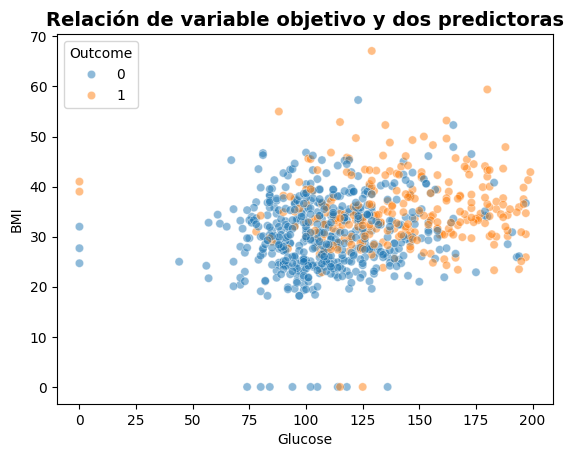

In [5]:
sns.scatterplot(
    data = diabetes,
    x = "Glucose",
    y = "BMI",
    hue = "Outcome",
    alpha = 0.5
)
plt.title("Relación de variable objetivo y dos predictoras", fontsize=14, fontweight="bold")
plt.show()

# Árbol de decisión

Para la construcción de un árbol de decisión, primero debemos definir una métrica a optimizar. En el caso de los árboles de decisión, una métrica que podemos optimizar es la *entropía*. En donde a medida que vamos tomando decisiones buscamos ganar información o disminuir la entropía.

La definición de entropía que utilizaremos es la siguiente:

$$
H(X)=- \sum_{i}p(x_i) \log_2 p(x_i)
$$

Donde $X$ es el conjunto de etiquetas.

In [6]:
def entropy(data : np.array) -> float:
  classes = np.unique(data)
  entropies = []
  for c in classes:
    p = sum(data == c) / len(data)
    current_entropy = p * np.log2(p)
    entropies.append(current_entropy)
  return -1 * sum(entropies)

Para comenzar, podemos estimar la entropía total del conjunto de datos

In [7]:
entropy(diabetes.Outcome)

0.9331343166407831

Ahora, debemos tomar una decisión, con la cual buscamos disminuir la entropía de cada uno de los subconjuntos obtenidos posterior a la decisión.

In [8]:
entropy(diabetes.Outcome[diabetes.Glucose >= 175])

0.6699960320994333

In [9]:
entropy(diabetes.Outcome[diabetes.Glucose < 175])

0.8941290186253704

Para estimar la entropía general de la decisión que tomamos debemos calcular un promedio ponderado de cada una de las entropías de cada subconjunto de datos.

In [10]:
def weighted_entropy(data : pd.DataFrame, feature : str, label : str, threshold : int):
  indices = data[feature] >= threshold
  entropy_0 = entropy(data[label][indices])
  entropy_1 = entropy(data[label][~indices])
  return entropy_0 * (sum(indices) / len(indices)) + entropy_1 * (sum(~indices) / len(indices))


In [11]:
weighted_entropy(diabetes, "Glucose", "Outcome", 175)

0.8774941485316485

Para determinar la mejor variable y el mejor umbral para la decisión del nodo del árbol debemos optimizar la ganancia de información de la decisión con la siguiente definición:

$$
IG(Y,X) = E(Y) - E(Y|X)
$$

Donde a la entropía total del conjunto de datos $E(Y)$ le restamos la entropía promedio $E(Y|X)$ de la decisión $Y$.

In [12]:
entropy(diabetes.Outcome) - weighted_entropy(diabetes, "Glucose", "Outcome", 175)

0.055640168109134525

Calculamos las entropías asociadas a un barrido de umbrales en un par de variables.

In [13]:
glucose_information_gain_sweep = []
glucose_thresholds = np.linspace(diabetes.Glucose.min(), diabetes.Glucose.max(), 100)
for threshold in glucose_thresholds:
  glucose_information_gain_sweep.append(entropy(diabetes.Outcome) - weighted_entropy(diabetes, "Glucose", "Outcome", threshold))

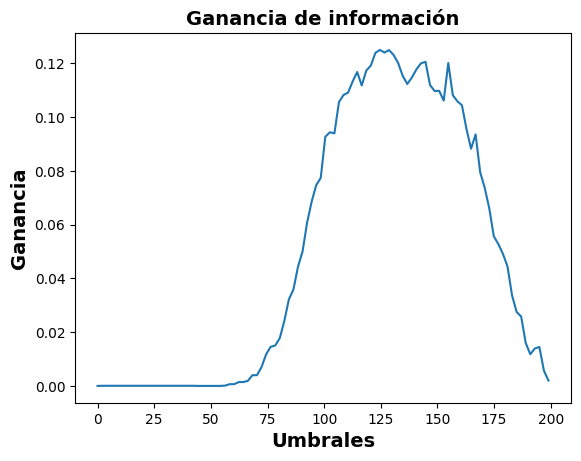

In [14]:
sns.lineplot(
    x = glucose_thresholds,
    y = glucose_information_gain_sweep
)
plt.title("Ganancia de información", fontsize=14, fontweight="bold")
plt.xlabel("Umbrales", fontsize=14, fontweight="bold")
plt.ylabel("Ganancia", fontsize=14, fontweight="bold");

In [15]:
bmi_information_gain_sweep = []
bmi_thresholds = np.linspace(diabetes.BMI.min(), diabetes.BMI.max(), 100)
for threshold in bmi_thresholds:
  bmi_information_gain_sweep.append(entropy(diabetes.Outcome) - weighted_entropy(diabetes, "BMI", "Outcome", threshold))

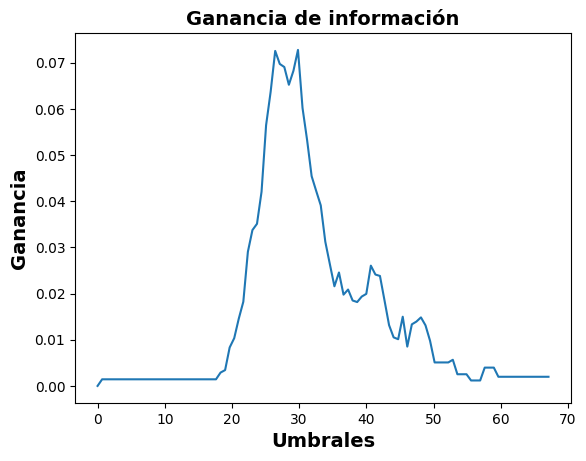

In [16]:
sns.lineplot(
    x = bmi_thresholds,
    y = bmi_information_gain_sweep
)
plt.title("Ganancia de información", fontsize=14, fontweight="bold")
plt.xlabel("Umbrales", fontsize=14, fontweight="bold")
plt.ylabel("Ganancia", fontsize=14, fontweight="bold");

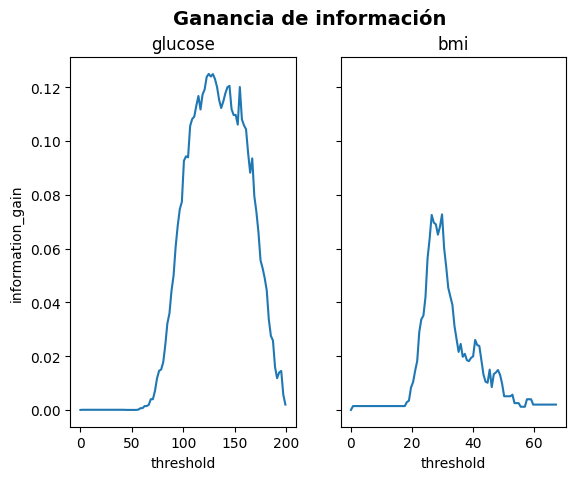

In [17]:
fig, axs = plt.subplots(nrows=1,ncols=2, sharey=True)
sns.lineplot(
    x = glucose_thresholds,
    y = glucose_information_gain_sweep,
    ax = axs[0]
)
sns.lineplot(
    x = bmi_thresholds,
    y = bmi_information_gain_sweep,
    ax = axs[1]
)
axs[0].set_title("glucose")
axs[1].set_title("bmi")
axs[0].set_ylabel("information_gain")
axs[0].set_xlabel("threshold")
axs[1].set_xlabel("threshold")
plt.suptitle("Ganancia de información",fontsize=14, fontweight="bold");

Seleccionamos el umbral que nos aporta la mayor ganancia de información.

In [18]:
optimal_glucose_threshold = glucose_thresholds[np.argmax(glucose_information_gain_sweep)]
optimal_glucose_threshold

124.62626262626262

In [19]:
entropy(diabetes.Outcome[diabetes.Glucose >= optimal_glucose_threshold])

0.9773203829731114

In [20]:
entropy(diabetes.Outcome[diabetes.Glucose < optimal_glucose_threshold])

0.6930190480473644

Utilizamos la implementación del árbol de decisión de sklearn para calcular la misma decisión.

In [21]:
single_decision = DecisionTreeClassifier(max_depth=1, criterion = "entropy")
single_decision = single_decision.fit(diabetes[["Glucose", "BMI"]], diabetes.Outcome)

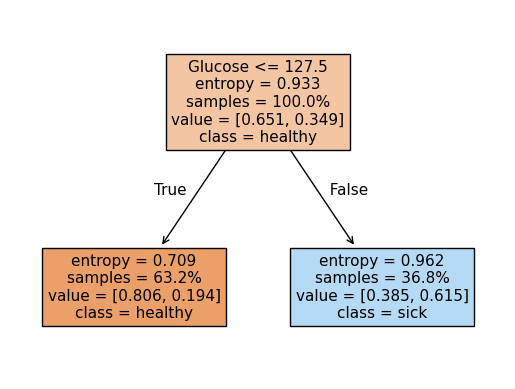

In [22]:
plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    single_decision, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = ["Glucose", "BMI"], # Nombres de las variables utilizadas para entrenar.
    class_names = ["healthy","sick"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Coloreamos los nodos
    fontsize=11, # Establecemos el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

Preparamos el conjunto de datos para poder ajustar un árbol de decisión de mayor profundidad.

In [23]:
diabetes_features = diabetes.iloc[:,:-1]
diabetes_label = diabetes.Outcome

In [24]:
(
    diabetes_features_train,
    diabetes_features_test,
    diabetes_label_train,
    diabetes_label_test
) = train_test_split(diabetes_features, diabetes_label, test_size=0.33, random_state=29)

In [25]:
tree = DecisionTreeClassifier( # Instanciamos nuestro árbol de decisión.
    max_depth=3, # Forzamos que nuestro árbol sólo tenga 3 niveles de profundidad.
    criterion = "entropy"
    )
tree.fit( # Ajustamos nuestro árbol de decisión.
    diabetes_features_train,
    diabetes_label_train
)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

Calculamos el rendimiento de nuestro árbol de decisión.

In [26]:
print(classification_report(
    diabetes_label_test,
    tree.predict(diabetes_features_test), target_names=["healthy","sick"]
))

              precision    recall  f1-score   support

     healthy       0.74      0.93      0.82       164
        sick       0.75      0.40      0.52        90

    accuracy                           0.74       254
   macro avg       0.74      0.66      0.67       254
weighted avg       0.74      0.74      0.72       254



Visualizamos el árbol de decisión.

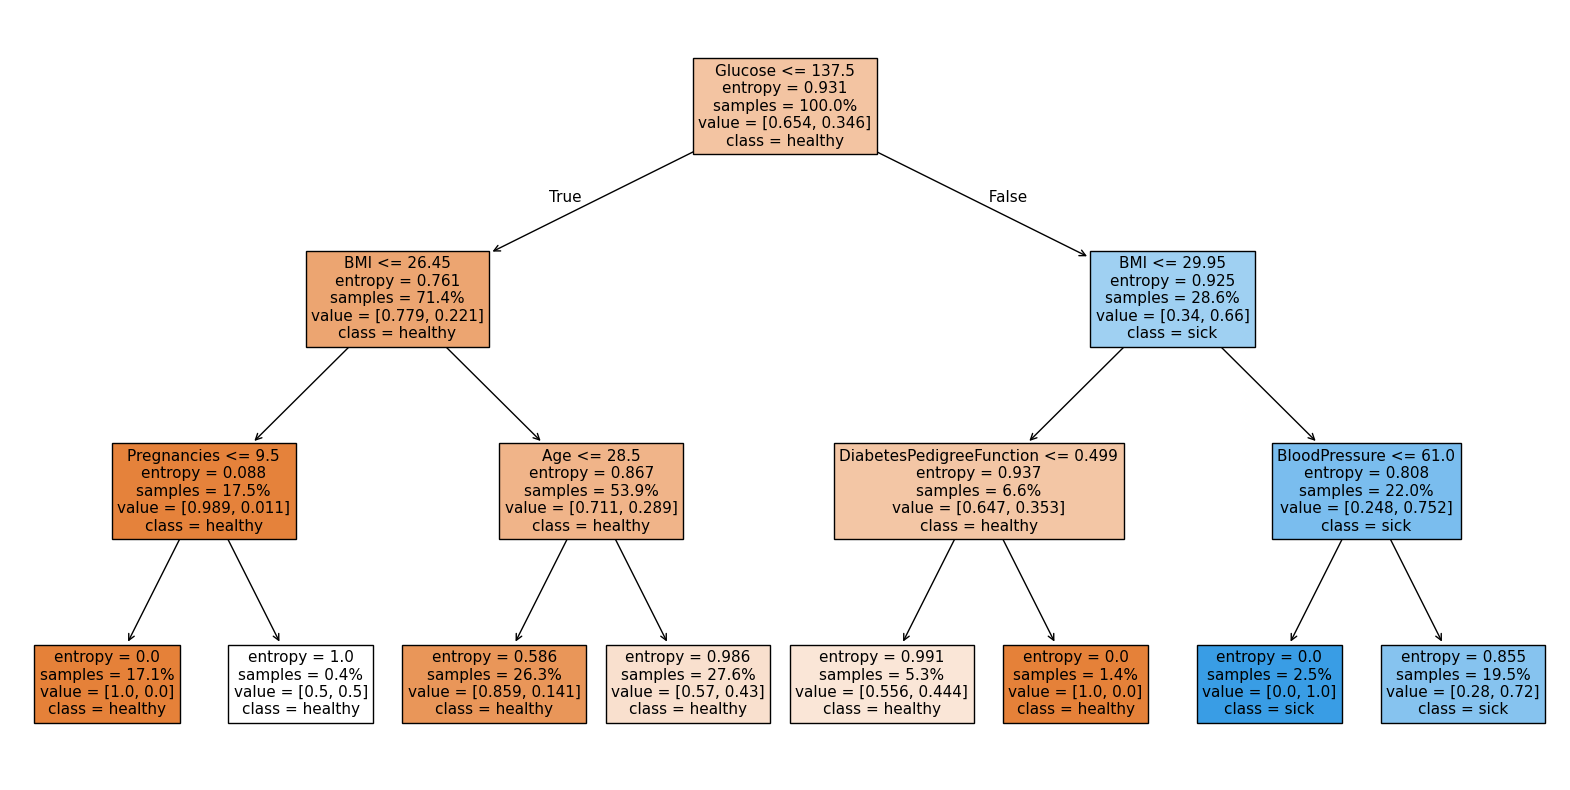

In [27]:
plt.figure(figsize = (20,10))
plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    tree, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = diabetes_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["healthy","sick"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Coloreamos los nodos
    fontsize=11, # Establecemos el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

Un hiperparámetro que podemos ajustar en un árbol de decisión es la profundidad máxima. Visualizamos que tenemos un mejoramiento inicial del rendimiento al aumentar la profundidad, para después descender debido al sobreajuste.

In [28]:
depths = range(1,10)
performances = []
for depth in depths:
    current_tree = sklearn.tree.DecisionTreeClassifier( # Instanciamos nuestro árbol de decisión.
        max_depth=depth,
        criterion = "entropy"
    )
    roc_auc = cross_val_score(
          current_tree,
          diabetes_features,
          diabetes_label,
          scoring="roc_auc"
      ).mean()
    performances.append(roc_auc)

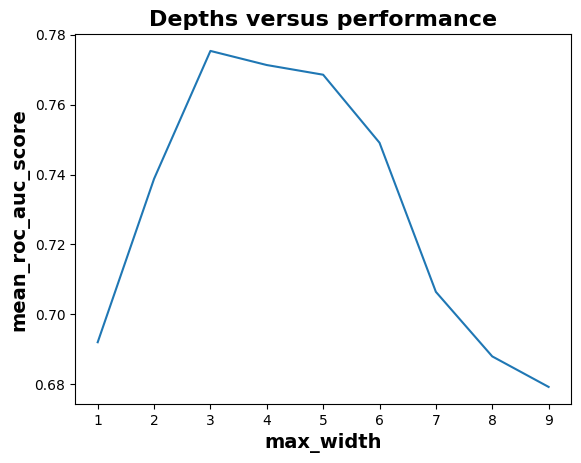

In [29]:
plt.plot(
    depths,
    performances
)
plt.xlabel("max_width", fontsize=14, fontweight="bold")
plt.ylabel("mean_roc_auc_score", fontsize=14, fontweight="bold")
plt.title("Depths versus performance", fontsize=16, fontweight="bold")
plt.show()

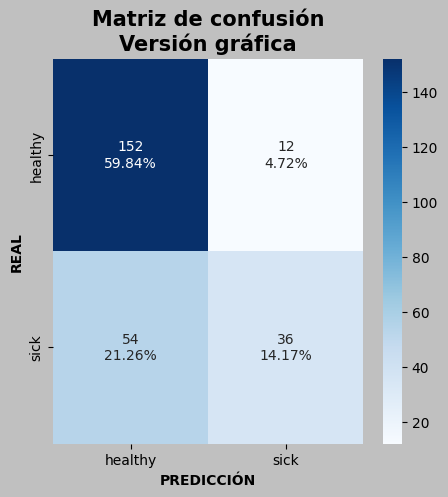

In [32]:
# Matriz de confusión de forma gráfica
matriz = confusion_matrix(diabetes_label_test, tree.predict(diabetes_features_test))
plt.figure(figsize=(5,5),facecolor= 'silver')
clases = ["healthy","sick"]
group_counts = ["{0:0.0f}".format(value) for value in matriz.flatten()]
# Calcula porcentajes
group_percentages = ["{0:.2%}".format(value) for value in matriz.flatten()/matriz.sum()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
# Genera la gráfica
sns.heatmap(matriz, annot=labels, fmt='', cmap='Blues', xticklabels=clases, yticklabels=clases)
plt.title("Matriz de confusión\nVersión gráfica", fontsize=15, fontweight="bold")
plt.xlabel("PREDICCIÓN", fontsize=10, fontweight="bold")
plt.ylabel("REAL", fontsize=10, fontweight="bold")
plt.show()